In [1]:
# for the moment the directory should be set to the parent to be able to use the LIPS package
import os
os.chdir(os.path.pardir)

## TOC:
* [Benchmark1](#benchmark1)
* [Benchmark2](#benchmark2)
* [Benchmark3](#benchmark3)

In this notebook you will learn how to create an augmented simulator and how to train it. 

As always on these notebooks, we use the `Benchmark1` to demonstrate how to perform this task.

On the first section, we explain how to use a model that is already available on this reposotiry. The second section is dedicated to the explanation of what is needed to create a different kind of `AugmentedSimulator` with a different Neural Network archiecture with a customized loss etc.

# Benchmark1 <a class="anchor" id="benchmark1"></a>

## Load the benchmark dataset

As always the first step is always to load our dataset.

In [ ]:
import os
from lips.benchmark import PowerGridBenchmark
path_benchmark = os.path.join("reference_data")
log_path = os.path.abspath(os.path.join("lips","logger","logs.log"))
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                path_benchmark=path_benchmark,
                                load_data_set=True,
                                log_path=log_path
                               )

## Train an available model (Fully Connected)

In this section we explain how to tune an available model. We take the example of the `FullyConnectedAS` that is an available fully connected neural network.

This section supposes that you already have a "model" (for example based on neural networks) that meets the `AugmentedSimulator` interface. If you do not have it already, the next section will cover the main principles.

**NB** The creation of the 'augmented_simulator' depends on each type of 'augmented_simulator'. 

The first step is to create the class you want to use, with the meta parameters you want to test. For this example:

In [ ]:
path_save = os.path.join("trained_models")
if not os.path.exists(path_save):
    os.mkdir(path_save)

from tensorflow.keras.layers import Dense
from lips.augmented_simulators import FullyConnectedAS

# the three lines bellow might be familiar to the tensorflow users. They tell tensorflow to not take all
# the GPU video RAM for the model.
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for el in physical_devices:
    tf.config.experimental.set_memory_growth(el, True)

fc_simulator = FullyConnectedAS(name="FullyConnectedAS_neuripsbenchmark1",
                                # `Benchmark_name` should correspond to one of config sections created earlier
                                benchmark_name="Benchmark1",
                                # the path of the config file, None uses the default config file
                                path_config=None,                                                                
                                # `attr_x` represents the variables of the dataset you want to use to predict 
                                # the output.
                                #attr_x=("prod_p", "prod_v", "load_p", "load_q", "line_status", "topo_vect"),
                                # `attr_y` represents the variables of the dataset you want to predict
                                # we predict everything needed, you can try to change them if you want, add some 
                                # others etc.
                                #attr_y=("a_or", "a_ex"),
                                # `sizes_layer` represents the size of each hidden layer in the neural network. The number
                                # of layers is determined by the length of this list, for example
                                sizes_layer=(300, 300, 300, 300),
                                # `lr` is the learning rate
                                lr=3e-4, 
                                # `layer` is the type of keras layer you want to use. We don't recommend to 
                                # change it
                                layer=Dense,
                                # `layer_act` is the activation function you want to use after each layer
                                layer_act="relu",
                                # `loss` is the training loss
                                loss="mse",  # loss used to train the model
                                # `batch_size` is the size of the batch for training
                                batch_size=128,
                                # `log_path` where to log the outputs 
                                log_path=log_path
                               )

Then you need to train it. For example here we will train it for 200 epochs.

**NB** You are responsible to use the correct dataset for training your model ! You can make experiments by training on the `test` set or on the `test_ood_topo` set if you want but we don't recommend you do to so !

**NB** This code is generic and should work for all `AugementedSimulator`

In [ ]:
fc_simulator.train(nb_iter=200,
                   train_dataset=benchmark1.train_dataset,
                   val_dataset=benchmark1.val_dataset)

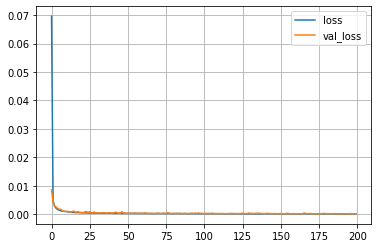

In [5]:
# convergence curve
from matplotlib import pyplot as plt
plt.plot(fc_simulator._model.history.history["loss"], label="loss")
plt.plot(fc_simulator._model.history.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()
plt.show()

And then you can save it:

In [15]:
fc_simulator.save(path_save)
fc_simulator.save_metadata(path_save)

or load a trained model

In [ ]:
fc_simulator.load_metadata(path_save)
fc_simulator.init()
fc_simulator.restore(path_save)

###  Evaluate the augmented simulator

Or evaluate it on the test dataset as in the previous notebook:

In [ ]:
metrics_per_dataset = benchmark1.evaluate_simulator(fc_simulator,
                                                    batch_size=128,
                                                    dataset="all"
                                                   )

#### Evaluation results (test set)

In [6]:
dataset_name = "test"
ML_metrics = 0
print("{:<10} : {}".format("MAPE90", metrics_per_dataset[dataset_name][ML_metrics]["mape90"]))
print("{:<10} : {}".format("MAPE", metrics_per_dataset[dataset_name][ML_metrics]["mape_avg"]))
print("{:<10} : {}".format("NRMSE_avg", metrics_per_dataset[dataset_name][ML_metrics]["NRMSE_avg"]))
print("{:<10} : {}".format("MAE_avg", metrics_per_dataset[dataset_name][ML_metrics]["MAE_avg"]))

MAPE90     : {'a_or': 0.0036846988704337517, 'a_ex': 0.003613642557877352}
MAPE       : {'a_or': 0.007488838702720867, 'a_ex': 0.0074977917104859125}
NRMSE_avg  : {'a_or': 0.002171390224248171, 'a_ex': 0.002145729260519147}
MAE_avg    : {'a_or': 1.25446355342865, 'a_ex': 1.7196712493896484}


#### Evaluation results (OOD set)

In [8]:
dataset_name = "test_ood_topo"
print("{:<10} : {}".format("MAPE90", metrics_per_dataset[dataset_name][ML_metrics]["mape90"]))
print("{:<10} : {}".format("MAPE", metrics_per_dataset[dataset_name][ML_metrics]["mape_avg"]))
print("{:<10} : {}".format("NRMSE_avg", metrics_per_dataset[dataset_name][ML_metrics]["NRMSE_avg"]))
print("{:<10} : {}".format("MAE_avg", metrics_per_dataset[dataset_name][ML_metrics]["MAE_avg"]))

MAPE90     : {'a_or': 0.49134532213153514, 'a_ex': 0.49184320518224567}
MAPE       : {'a_or': 0.7777106072151719, 'a_ex': 0.7782865198862863}
NRMSE_avg  : {'a_or': 0.22724822163581848, 'a_ex': 0.22774150967597961}
MAE_avg    : {'a_or': 133.911376953125, 'a_ex': 185.03323364257812}


In [9]:
dataset_name = "test_ood_topo"
print("{:<10} : {}".format("MAPE90", metrics_per_dataset[dataset_name][ML_metrics]["MAE90"]))

MAPE90     : {'a_or': 246.6368408203125, 'a_ex': 328.64532470703125}


Once saved, if you want to reuse it you can do exactly as we did in the previous notebook:
```python
relaoded_simulator = FullyConnectedAS(name="test_FullyConnectedAS")  # the name should match! The other things are loaded from the directory
relaoded_simulator.load_metadata(path_baselines)
relaoded_simulator.init()
relaoded_simulator.restore(path_baselines)
```

And you are good to go !

## LEAP nets
The leap nets allows to take into account the topology in the latent space, and have a more robust generalization performance than a simple fully connected model.

In [ ]:
path_save = os.path.join("trained_models")
if not os.path.exists(path_save):
    os.mkdir(path_save)

from tensorflow.keras.layers import Dense
from lips.augmented_simulators import LeapNetAS

# the three lines bellow might be familiar to the tensorflow users. They tell tensorflow to not take all
# the GPU video RAM for the model.
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for el in physical_devices:
    tf.config.experimental.set_memory_growth(el, True)

In [4]:
leapNet = LeapNetAS(name="leapNetAS_baseline",
                    # `Benchmark_name` should correspond to one of config sections created earlier
                    benchmark_name="Benchmark1",
                    # the path of the config file, None uses the default config file
                    path_config=None,       
                    # `attr_x` represents the variables of the dataset you want to use to predict 
                    # the output.
                    #attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                    # `attr_y` represents the variables of the dataset you want to predict
                    # we predict everything needed, you can try to change them if you want, add some 
                    # others etc.
                    #attr_y=("a_or", "a_ex"),
                    # `lr` is the learning rate
                    lr=3e-4, 
                    # `layer` is the type of keras layer you want to use. We don't recommend to 
                    # change it
                    layer=Dense,
                    # `layer_act` is the activation function you want to use after each layer
                    layer_act="relu",
                    # `loss` is the training loss
                    loss="mse",  # loss used to train the model
                    # `batch_size` is the size of the batch for training
                    batch_size=128,
                    # the method used to encode the topology vector
                    topo_vect_to_tau="all",
                    # `log_path` where to log the outputs 
                    log_path=log_path
                   )

### Train the model 

In [ ]:
leapNet.train(nb_iter=200,
              train_dataset=benchmark1.train_dataset,
              val_dataset=benchmark1.val_dataset
             )

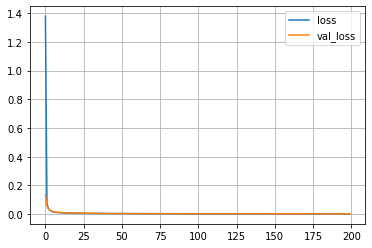

In [10]:
# convergence curve
from matplotlib import pyplot as plt
plt.plot(leapNet._leap_net_model._model.history.history["loss"], label="loss")
plt.plot(leapNet._leap_net_model._model.history.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()
plt.show()

And then you can save it:

In [11]:
leapNet.save(path_save)
leapNet.save_metadata(path_save)

### Evaluate the model 

In [ ]:
leapNet_metrics_per_dataset = benchmark1.evaluate_simulator(leapNet,
                                                            batch_size=128,
                                                            dataset="all"
                                                           )

#### Evaluation results (test set)

In [13]:
dataset_name = "test"
ML_metrics = 0
print("{:<10} : {}".format("MAPE90", leapNet_metrics_per_dataset[dataset_name][ML_metrics]["mape90"]))
print("{:<10} : {}".format("MAPE", leapNet_metrics_per_dataset[dataset_name][ML_metrics]["mape90"]))
print("{:<10} : {}".format("NRMSE_avg", leapNet_metrics_per_dataset[dataset_name][ML_metrics]["NRMSE_avg"]))
print("{:<10} : {}".format("MAE_avg", leapNet_metrics_per_dataset[dataset_name][ML_metrics]["MAE_avg"]))

MAPE90     : {'a_or': 0.007304894253511589, 'a_ex': 0.00789745218045187}
MAPE       : {'a_or': 0.007304894253511589, 'a_ex': 0.00789745218045187}
NRMSE_avg  : {'a_or': 0.00418089097365737, 'a_ex': 0.004608687479048967}
MAE_avg    : {'a_or': 2.405794620513916, 'a_ex': 4.079007148742676}


#### Evaluation results (OOD set)

In [14]:
dataset_name = "test_ood_topo"
print("{:<10} : {}".format("MAPE90", leapNet_metrics_per_dataset[dataset_name][ML_metrics]["mape90"]))
print("{:<10} : {}".format("MAPE", leapNet_metrics_per_dataset[dataset_name][ML_metrics]["mape_avg"]))
print("{:<10} : {}".format("NRMSE_avg", leapNet_metrics_per_dataset[dataset_name][ML_metrics]["NRMSE_avg"]))
print("{:<10} : {}".format("MAE_avg", leapNet_metrics_per_dataset[dataset_name][ML_metrics]["MAE_avg"]))

MAPE90     : {'a_or': 0.5187410728590817, 'a_ex': 0.5220914060649886}
MAPE       : {'a_or': 0.9047375334168853, 'a_ex': 0.9056593851351682}
NRMSE_avg  : {'a_or': 0.22477559745311737, 'a_ex': 0.22402051091194153}
MAE_avg    : {'a_or': 145.4780731201172, 'a_ex': 206.4204864501953}


# Code another type of "augmented_simulator"

We provide only a single type of augmented simulator as of now. More baselines will be added with, we hope the growth of the community.

Coding another type of "augmented simulator" is not difficult. Finding one that work well for all the criteria is of course a different challenge.

Basically, an augmented simulator should:

- inherit from `AugmentedSimulator`
- implements the methods `save_metadata` and `load_metadata`
- implements the methods `save` and `restore`
- implements the method `init` that can for example, create the neural network from its meta parameters
- implements the method `train` that will train the augmented simulator for a given number of steps (it is not mandatory to make such function, some `AugmentedSimulator` might not require any training at all)
- implements the method `predict` method that will make some predictions and return a dictionnary containing the predictions for all variable types.

More information is given on the documentation. And a fully working example is given in the `FullyConnectedAS` class.

This is it, nothing more is required.

# Benchmark2 <a class="anchor" id="benchmark2"></a>

In [15]:
import os
from lips.benchmark import PowerGridBenchmark
path_benchmark = os.path.join("reference_data")
log_path = os.path.abspath(os.path.join("lips","logger","logs.log"))
benchmark2 = PowerGridBenchmark(benchmark_name="Benchmark2",
                                path_benchmark=path_benchmark,
                                load_data_set=True,
                                log_path=log_path
                               )

## Fully Connected model

In [16]:
path_save = os.path.join("trained_models")
if not os.path.exists(path_save):
    os.mkdir(path_save)

from tensorflow.keras.layers import Dense
from lips.augmented_simulators import FullyConnectedAS

# the three lines bellow might be familiar to the tensorflow users. They tell tensorflow to not take all
# the GPU video RAM for the model.
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for el in physical_devices:
    tf.config.experimental.set_memory_growth(el, True)

fc_simulator_benchmark2 = FullyConnectedAS(name="FullyConnectedAS_benchmark2",
                                           benchmark_name="Benchmark2",
                                           path_config=None,                                                                
                                           sizes_layer=(300, 300, 300, 300),
                                           lr=3e-4, 
                                           layer=Dense,
                                           layer_act="relu",
                                           loss="mse",
                                           batch_size=128,
                                           log_path=log_path
                                          )

In [ ]:
fc_simulator_benchmark2.train(nb_iter=200,
                              train_dataset=benchmark2.train_dataset,
                              val_dataset=benchmark2.val_dataset)

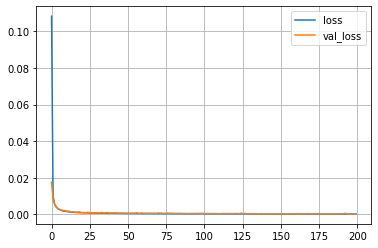

In [18]:
# convergence curve
from matplotlib import pyplot as plt
plt.plot(fc_simulator_benchmark2._model.history.history["loss"], label="loss")
plt.plot(fc_simulator_benchmark2._model.history.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()
plt.show()

And then you can save it:

In [19]:
fc_simulator_benchmark2.save(path_save)
fc_simulator_benchmark2.save_metadata(path_save)

###  Evaluate the augmented simulator

Or evaluate it on the test dataset as in the previous notebook:

In [ ]:
fc_b2_metrics_per_dataset = benchmark2.evaluate_simulator(fc_simulator_benchmark2,
                                                          batch_size=128,
                                                          dataset="all"
                                                         )

#### Evaluation results (test set)

In [10]:
dataset_name = "test"
ML_metrics = 0
print("{:<10} : {}".format("MAPE90", fc_b2_metrics_per_dataset[dataset_name][ML_metrics]["mape90"]))
print("{:<10} : {}".format("MAPE", fc_b2_metrics_per_dataset[dataset_name][ML_metrics]["mape_avg"]))
print("{:<10} : {}".format("NRMSE_avg", fc_b2_metrics_per_dataset[dataset_name][ML_metrics]["NRMSE_avg"]))
print("{:<10} : {}".format("MAE_avg", fc_b2_metrics_per_dataset[dataset_name][ML_metrics]["MAE_avg"]))

NameError: name 'fc_b2_metrics_per_dataset' is not defined

#### Evaluation results (OOD set)

In [22]:
dataset_name = "test_ood_topo"
print("{:<10} : {}".format("MAPE90", fc_b2_metrics_per_dataset[dataset_name][ML_metrics]["mape90"]))
print("{:<10} : {}".format("MAPE", fc_b2_metrics_per_dataset[dataset_name][ML_metrics]["mape_avg"]))
print("{:<10} : {}".format("NRMSE_avg", fc_b2_metrics_per_dataset[dataset_name][ML_metrics]["NRMSE_avg"]))
print("{:<10} : {}".format("MAE_avg", fc_b2_metrics_per_dataset[dataset_name][ML_metrics]["MAE_avg"]))

MAPE90     : {'a_or': 0.49284537256946476, 'a_ex': 0.49337871771289465, 'p_or': 0.7320050531283904, 'p_ex': 0.7246586165254219, 'q_or': 1.084355255484176, 'q_ex': 1.0131807425052672, 'v_or': 0.06668068052933186, 'v_ex': 0.06717003251853844}
MAPE       : {'a_or': 0.7936752175143977, 'a_ex': 0.8051561091035806, 'p_or': 1.2323162078745304, 'p_ex': 1.2239979491874782, 'q_or': 1.004157290743756, 'q_ex': 1.1002375129247894, 'prod_q': 0.39205302413787096, 'load_v': 0.010514315739886253, 'v_or': 0.06545680301624221, 'v_ex': 0.06608044038963129}
NRMSE_avg  : {'a_or': 0.19161993265151978, 'a_ex': 0.19161586463451385, 'p_or': 0.1846400797367096, 'p_ex': 0.18571999669075012, 'q_or': 0.1775209903717041, 'q_ex': 0.1674838364124298, 'prod_q': 0.17315997183322906, 'load_v': 0.12535180151462555, 'v_or': 0.28644752502441406, 'v_ex': 0.2776208221912384}
MAE_avg    : {'a_or': 140.25558471679688, 'a_ex': 193.94479370117188, 'p_or': 14.41413688659668, 'p_ex': 14.199621200561523, 'q_or': 5.297982215881348, '

## LeapNet model

# Benchmark3 <a class="anchor" id="benchmark3"></a>

## Fully Connected model

## LeapNet model